In [740]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nussl
from utils import viz, data
import yaml
import os

In [741]:
import json
from nussl.datasets import transforms as nussl_tfm
from pathlib import Path

In [742]:
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
from models.Filterbank import Filterbank
from models.Waveform import Waveform
from models.WaveUNet import WaveUNet

nussl.ml.register_module(MaskInference)
nussl.ml.register_module(UNetSpect)
nussl.ml.register_module(Filterbank)
nussl.ml.register_module(Waveform)
nussl.ml.register_module(WaveUNet)

In [743]:
os.listdir('models/')

['.ipynb_checkpoints',
 'WaveUNet.py',
 '__pycache__',
 'MaskInference.py',
 'filterbank_default',
 'Waveform.py',
 'UNet.py',
 'Filterbank.py',
 'overfit',
 'mask_default',
 'Clustering.py',
 'VocalSepOnly']

In [758]:
model_name = 'overfit'
#model_name = 'filterbank_default'
model_name = 'mask_default'

In [759]:
model_path = 'models/'+model_name+'/checkpoints/latest.model.pth'
config_path = 'models/'+model_name+'/configs.yml'
#Optimizer checkpoints no longer stored
#optimizer_path = 'models/'+model_name+'/checkpoints/latest.optimizer.pth'

In [760]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()

model_type = configs['model_type']
waveform_models = ['Filterbank','Waveform','WaveUNet']
if model_type in waveform_models:
    stft_params = None
    
    tfm = nussl_tfm.Compose([
        #nussl_tfm.SumSources([['bass', 'drums', 'other']]),
        nussl_tfm.GetAudio(),
        #nussl_tfm.IndexSources('source_audio', 1),
        nussl_tfm.ToSeparationModel(),
    ])
    
    separator = nussl.separation.deep.DeepAudioEstimation(
        nussl.AudioSignal(), model_path=model_path,
        device='cpu',
    )
    
    target_key = 'source_audio'
    output_key = 'audio'
    
else:
    stft_params = nussl.STFTParams(**configs['stft_params'])
    
    tfm = nussl_tfm.Compose([
        #nussl_tfm.SumSources([['bass', 'drums', 'other']]),
        nussl_tfm.MagnitudeSpectrumApproximation(),
        #nussl_tfm.IndexSources('source_magnitudes', 1),
        nussl_tfm.ToSeparationModel(),
    ])
    
    separator = nussl.separation.deep.DeepMaskEstimation(
        nussl.AudioSignal(), model_path=model_path,
        device='cpu',
    )
    
    target_key = 'source_magnitudes'
    output_key = 'estimates'

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


In [761]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
#Optimizer checkpoints no longer stored
#optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [762]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 10,
 'epoch_length': 10,
 'max_epochs': 10,
 'output': {'loss': 0.0012949208030477166},
 'metrics': {'avg_loss': 0.0011957066380382038},
 'seed': None}

In [763]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

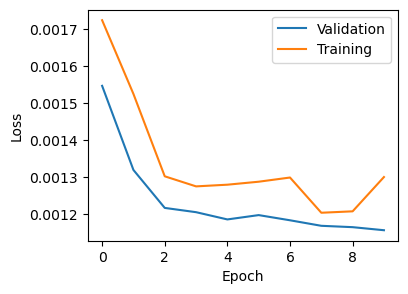

In [764]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss,label='Validation')
plt.plot(x,train_loss,label='Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

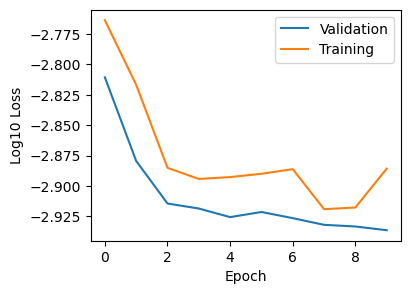

In [765]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,np.log10(val_loss),label='Validation')
plt.plot(x,np.log10(train_loss),label='Training')
plt.ylabel('Log10 Loss')
plt.xlabel('Epoch')
plt.legend()

In [766]:
#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=tfm, fg_path=configs['test_folder'], num_mixtures=50, coherent_prob=1.0, duration=5)
test_dataloader = torch.utils.data.DataLoader(test_data, num_workers=1, batch_size=1)

In [767]:
for i,batch in enumerate(test_dataloader):
    if i==1:
        batch=batch
        break
    
for key in batch:
    if torch.is_tensor(batch[key]):
        batch[key] = batch[key].float().to('cpu')   

In [768]:
#torch.Size([2, 6892, 65, 1, 1])
#torch.Size([2, 6892, 65, 1, 4])

In [769]:
batch[target_key].shape

torch.Size([1, 6892, 65, 1, 4])

In [770]:
output = separator.model(batch)

In [771]:
output[output_key].shape

torch.Size([1, 6892, 65, 1, 4])

In [739]:
out = output[output_key].detach().numpy()
target = batch[target_key].detach().numpy()

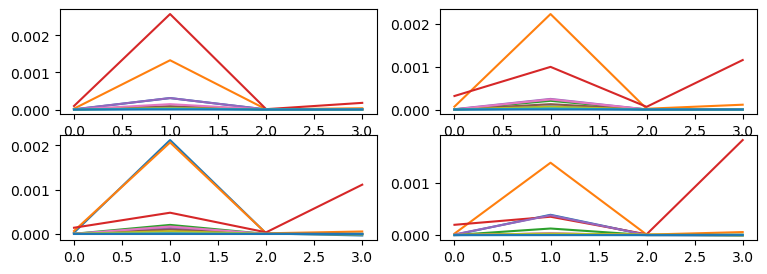

In [717]:
fig, axs = plt.subplots(2,2,figsize=(9,3))
axs[0,0].plot(out.squeeze()[0,::100].T)
axs[0,1].plot(out.squeeze()[1,::100].T)
axs[1,0].plot(out.squeeze()[2,::100].T)
axs[1,1].plot(out.squeeze()[3,::100].T)

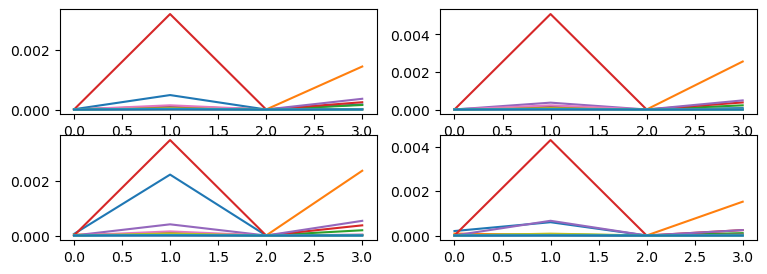

In [718]:
fig, axs = plt.subplots(2,2,figsize=(9,3))
axs[0,0].plot(target.squeeze()[0,::100].T)
axs[0,1].plot(target.squeeze()[1,::100].T)
axs[1,0].plot(target.squeeze()[2,::100].T)
axs[1,1].plot(target.squeeze()[3,::100].T)

In [719]:
np.mean((target-out)**2)

loss_fn = torch.nn.MSELoss()
loss_fn(torch.tensor(target),torch.tensor(out))

loss_fn = torch.nn.L1Loss()
loss_fn(torch.tensor(target),torch.tensor(out))

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 432, 1024, 4, 1])) that is different to the input size (torch.Size([1, 432, 1024, 1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 432, 1024, 4, 1])) that is different to the input size (torch.Size([1, 432, 1024, 1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(0.0003)

In [720]:
#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=None, fg_path=configs['test_folder'], num_mixtures=50, coherent_prob=1.0, duration=5)

In [721]:
item = test_data[1]
separator.audio_signal = item['mix']
estimates = separator()
viz.show_sources(estimates)

ValueError: Cannot support arrays with more than 3 dimensions!